In [8]:
from threshold_regression import *

from adios2toolspy import SuperCell, BpParticles, BpFields
from h5toolspy import H5Processor
from picplot import fieldGrid, histGrid
import matplotlib
import numpy as np
import pandas as pd
from scipy.ndimage import convolve

import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans

%matplotlib inline 
plt.rcParams['figure.figsize'] = [20, 12]

In [9]:
root = '/mnt/lustre/germaschewski/jca32/psc/build/smallRun2/'

dt =  0.175009  
dx= 0.25 #dx/de 
dy, dz = 4, 0.25 # dy/de, dz/de 

root = '/mnt/lustre/germaschewski/jca32/psc/build/largeRun5/' ##mass ratio = 25
dt =   0.0614459  ## largeRun2/5
dx=  0.0887784 #dx/de 
dy, dz = 5, 0.0868056 # dy/de, dz/de 

root = '/mnt/lustre/germaschewski/jca32/psc/build/largeRun6/' ##mass ratio = 25
dt =   0.0683629  ## largeRun6
dx=  0.0976562 #dx/de 
dy, dz = 5, 0.0976562 # dy/de, dz/de 0.0976562

In [10]:
def averaging(arr):
    tmp = arr
    for i in range(3):
        tmp = convolve(tmp, np.ones((3,3))/9)
#         tmp = convolve(tmp, dx*dz*np.ones((3,3)))

    return tmp

def fc_to_nc(x, dim='x'):
    h, w = x.shape
    tmp = np.zeros((h,w))
    if dim == 'x':
        tmp[1:,:] = 0.5*(x[:-1,:] + x[1:,:])
    elif dim == 'y':
        tmp[1:,1:] = 0.25*(x[1:,1:] + x[:-1,1:] + x[1:,:-1] + x[:-1,:-1])
    else: #'z'
        tmp[:,1:] = 0.5*(x[:,:-1] + x[:,1:])

    return tmp

def ec_to_nc(x, dim='x'):
    h, w = x.shape
    tmp = np.zeros((h,w))
    if dim == 'x':
        tmp[:,1:] = 0.5*(x[:,1:] + x[:,:-1])
    if dim == 'y':
        return x
    else: # z
        tmp[1:,:] = 0.5*(x[1:,:] + x[:-1,:])
    return tmp

In [11]:
errors = lambda l, r, d: (np.linalg.norm(l-r)**2/np.linalg.norm(l)**2, np.linalg.norm(r-d)**2)/np.linalg.norm(r)**2
error  = lambda x1, x2: np.linalg.norm(x1 - x2) / np.linalg.norm(x1)
def coeff_error(pred_coeffs, true_coeffs):
    p = np.array(pred_coeffs)
    t = np.array(true_coeffs)
    
    error = np.linalg.norm(p - t) / np.linalg.norm(t)
    
h5p = H5Processor(root, timeAveraged=False)
time = 35 #used 29 for 10-moment verification, 35 for closure, both are in linear phase
tstep = 1
cutx, cutz = 5, 5 # edge points to slice off after taking spatial gradients
# zmin=-15 #domain slice  # no slices seems to give  better fits, plots look better sliced though so maybe fit full and then slice once metrics are taken
# zmax=15 #domain slice
# xmin=25 #domain slice
# xmax=100 #domain slice
# zmin=None #domain slice
# zmax=None #domain slice
# xmin=None #domain slice
# xmax=None #domain slice
## for closure
zmin, zmax = -10, 10
xmin, xmax = 60,80
load = lambda x, t: h5p.getH5Grid(x, t, zmin=zmin, zmax=zmax, xmin=xmin, xmax=xmax).data[:,0,:]
prep = lambda x, t: averaging(load(x, t))[cutz:-cutz, cutx:-cutx].flatten()
d_dx = lambda x: ( (np.diff(x, axis=1, append=0) + np.diff(x, axis=1, prepend=0)) / dx / 2 )[cutz:-cutz, cutx:-cutx].flatten()
d_dz = lambda x: ( (np.diff(x, axis=0, append=0) + np.diff(x, axis=0, prepend=0)) / dz / 2 )[cutz:-cutz, cutx:-cutx].flatten()

In [15]:
def SE(A, B):
    return np.linalg.norm(A - B) / np.linalg.norm(A)

k_guess = 0.1

# SE(div_qxx_c, vt*k_guess*P_closure_xx), SE(div_qyy_c, vt*k_guess*P_closure_yy), SE(div_qzz_c, vt*k_guess*P_closure_zz)

In [16]:
dtxwce = 0.0341814


Loading rho_nc_e from File: pfd.011697.xdmf
Loading ex_ec from File: pfd.011697.xdmf
Loading ey_ec from File: pfd.011697.xdmf
Loading ez_ec from File: pfd.011697.xdmf
Loading hx_fc from File: pfd.011697.xdmf
Loading hy_fc from File: pfd.011697.xdmf
Loading hz_fc from File: pfd.011697.xdmf
Loading qxxx_nc_e from File: pfd.011697.xdmf
Loading qxxz_nc_e from File: pfd.011697.xdmf
Loading qyyx_nc_e from File: pfd.011697.xdmf
Loading qyyz_nc_e from File: pfd.011697.xdmf
Loading qzzx_nc_e from File: pfd.011697.xdmf
Loading qzzz_nc_e from File: pfd.011697.xdmf
Loading qxxy_nc_e from File: pfd.011697.xdmf
Loading qxyz_nc_e from File: pfd.011697.xdmf
Loading qzzy_nc_e from File: pfd.011697.xdmf
Loading rho_nc_e from File: pfd.011697.xdmf
Loading px_nc_e from File: pfd.011697.xdmf
Loading py_nc_e from File: pfd.011697.xdmf
Loading pz_nc_e from File: pfd.011697.xdmf
Loading tyy_nc_e from File: pfd.011697.xdmf
Loading txx_nc_e from File: pfd.011697.xdmf
Loading txy_nc_e from File: pfd.011697.xdmf


Text(0.0, 0.5, '$z/d_i$')

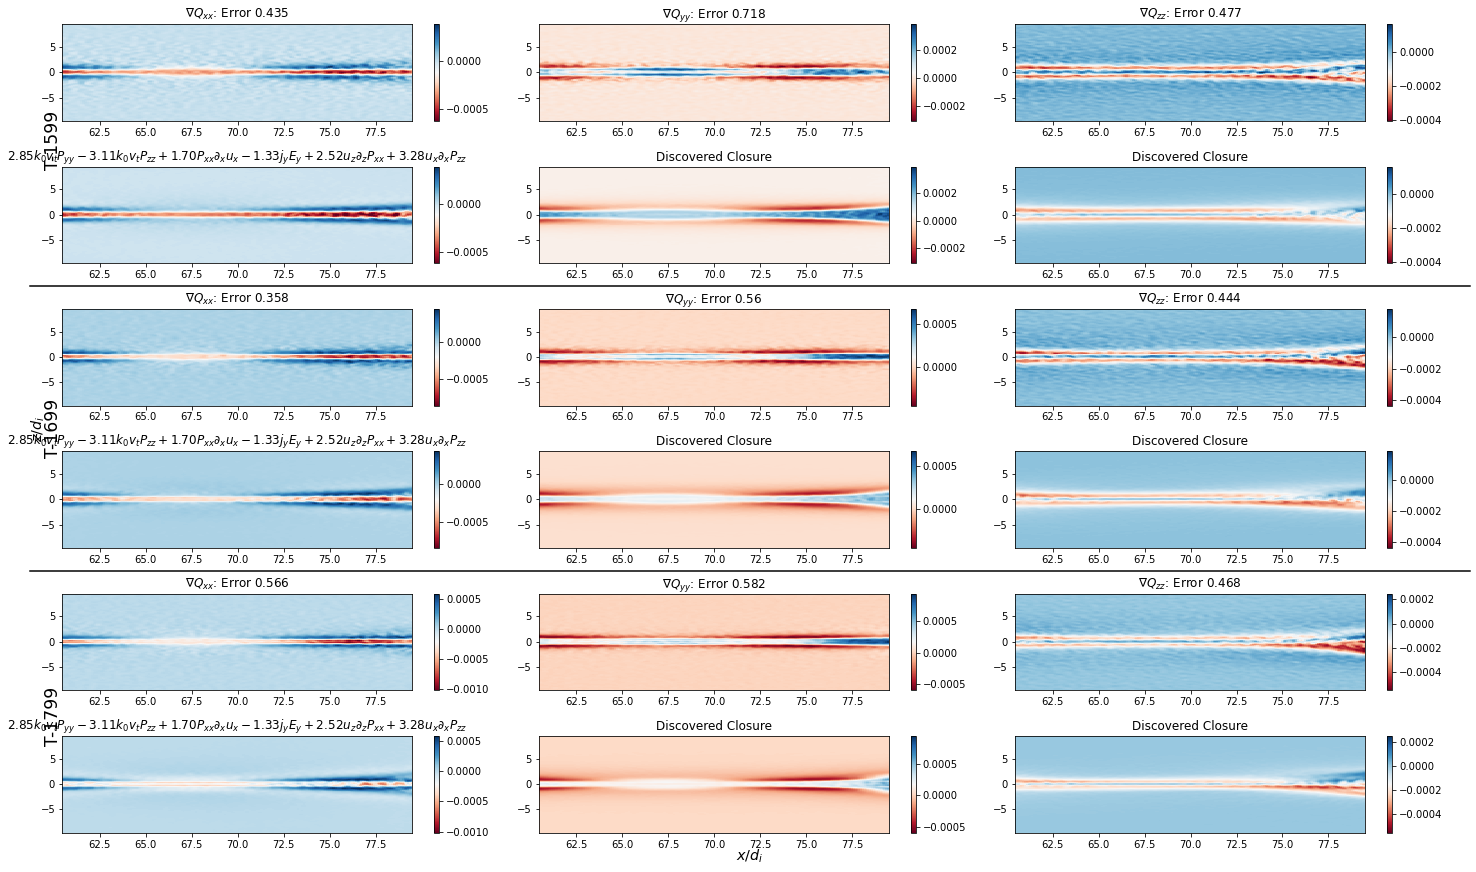

In [36]:
fig, axes = plt.subplots(6,3)
k_0=0.1
vt = 0.144338
dtxwce = 0.0341814
i=0
times = [33, 35, 37]
time_labels = []
for time in times:
    rho1 = h5p.getH5Grid('rho_nc_e', time, zmin=zmin, zmax=zmax, xmin=xmin, xmax=xmax)[cutz:-cutz, :, cutx:-cutx]
    xlin = np.linspace(rho1.coords['x'].min(), rho1.coords['x'].max(), rho1.shape[2])
    zlin = np.linspace(rho1.coords['z'].min(), rho1.coords['z'].max(), rho1.shape[0])
    time_labels.append(int(h5p.chkptTime)*dt / (dtxwce/dt))
    zshape,_, xshape = rho1.shape
    ex = load('ex_ec', time)
    ey = load('ey_ec', time)
    ez = load('ez_ec', time)
    bx = load('hx_fc', time)
    by = load('hy_fc', time)
    bz = load('hz_fc', time)
#     Ex = averaging(ec_to_nc(ex, dim='x'))[cutz:-cutz,cutx:-cutx].flatten()
#     Ey = averaging(ec_to_nc(ey, dim='y'))[cutz:-cutz,cutx:-cutx].flatten()
#     Ez = averaging(ec_to_nc(ez, dim='z'))[cutz:-cutz,cutx:-cutx].flatten()
#     Bx = averaging(fc_to_nc(bx, dim='x'))[cutz:-cutz,cutx:-cutx].flatten()
#     By = averaging(fc_to_nc(by, dim='y'))[cutz:-cutz,cutx:-cutx].flatten()
#     Bz = averaging(fc_to_nc(bz, dim='z'))[cutz:-cutz,cutx:-cutx].flatten()

#     n =  -prep('rho_nc_e', time)
#     n0 = -prep('rho_nc_e', time - tstep)
#     jx = prep('jx_nc_e', time)
#     jy = prep('jy_nc_e', time)
#     jz = prep('jz_nc_e', time)
#     jx0 = prep('jx_nc_e', time - tstep)
#     jy0 = prep('jy_nc_e', time - tstep)
#     jz0 = prep('jz_nc_e', time - tstep)
#     px1 = prep('px_nc_e', time)
#     px0 = prep('px_nc_e', time - tstep)
#     py1 = prep('py_nc_e', time)
#     py0 = prep('py_nc_e', time - tstep)
#     pz1 = prep('pz_nc_e', time)
#     pz0 = prep('pz_nc_e', time - tstep)

#     pxx1 = prep('txx_nc_e', time)
#     pxx0 = prep('txx_nc_e', time - tstep)
#     pyy1 = prep('tyy_nc_e', time)
#     pyy0 = prep('tyy_nc_e', time - tstep)
#     pzz1 = prep('tzz_nc_e', time)
#     pzz0 = prep('tzz_nc_e', time - tstep)
#     pxy1 =  prep('txy_nc_e', time)
#     pxy0 = prep('txy_nc_e', time-tstep)
#     pxz1 = prep('tzx_nc_e', time)
#     pxz0 = prep('tzx_nc_e', time - tstep)
#     pyz1 =  prep('tyz_nc_e', time)
#     pyz0 = prep('tyz_nc_e', time - tstep)

#     jx1, jy1, jz1 = jx, jy, jz
#     u1, u0 = -jx1, -jx0
#     v1, v0 = -jy1, -jy0
#     w1, w0 = -jz1, -jz0
#     r = -1
#     n1 = n

    qxxx = averaging(load('qxxx_nc_e', time))
    qxxz = averaging(load('qxxz_nc_e', time))
    d_qxxx_dx = d_dx(qxxx)
    d_qxxz_dz = d_dz(qxxz)
    div_qxx = d_qxxx_dx + d_qxxz_dz

    qyyx = averaging(load('qyyx_nc_e', time))
    qyyz = averaging(load('qyyz_nc_e', time))
    d_qyyx_dx = d_dx(qyyx)
    d_qyyz_dz = d_dz(qyyz)
    div_qyy = d_qyyx_dx + d_qyyz_dz

    qzzx = averaging(load('qzzx_nc_e', time))
    qzzz = averaging(load('qzzz_nc_e', time))
    d_qzzx_dx = d_dx(qzzx)
    d_qzzz_dz = d_dz(qzzz)
    div_qzz = d_qzzx_dx + d_qzzz_dz
    
    qxyx = averaging(load('qxxy_nc_e', time))
    qxyz = averaging(load('qxyz_nc_e', time))
    d_qxyx_dx = d_dx(qxyx)
    d_qxyz_dz = d_dz(qxyz)
    div_qxy = d_qxyx_dx + d_qxyz_dz
    
    qxzx = qxxz
    qxzz = qzzx
    d_qxzx_dx = d_dx(qxzx)
    d_qxzz_dz = d_dz(qxzz)
    div_qxz = d_qxzx_dx + d_qxzz_dz
    
    qyzx = qxyz
    qyzz = averaging(load('qzzy_nc_e', time))
    d_qyzx_dx = d_dx(qyzx)
    d_qyzz_dz = d_dz(qyzz)
    div_qyz = d_qyzx_dx + d_qyzz_dz
    
    ### Closure calculations done with the centered moment quantities, which is what c stands for

    c_prep = lambda x, t: averaging(h5p.getH5Grid(x, t, zmin=zmin, zmax=zmax, xmin=xmin, xmax=xmax).data[:,0,:])
    n_c =  -c_prep('rho_nc_e', time)
    px_c = c_prep('px_nc_e', time)
    py_c = c_prep('py_nc_e', time)
    pz_c = c_prep('pz_nc_e', time)
    pyy_c = c_prep('tyy_nc_e', time)
    pxx_c = c_prep('txx_nc_e', time)
    pxy_c =  c_prep('txy_nc_e', time)
    pxz_c = c_prep('tzx_nc_e', time)
    pzz_c = c_prep('tzz_nc_e', time)
    pyz_c =  c_prep('tyz_nc_e', time)

    qxxx_c = qxxx + 2*n_c*px_c*px_c*px_c - 3*px_c*pxx_c
    qxxz_c = qxxz + 2*n_c*px_c*px_c*pz_c - 2*px_c*pxz_c - pz_c*pxx_c

    qyyx_c = qyyx + 2*n_c*py_c*py_c*px_c - 2*py_c*pxy_c - px_c*pyy_c
    qyyz_c = qyyz + 2*n_c*py_c*py_c*pz_c - 2*py_c*pyz_c - pz_c*pyy_c

    qzzx_c = qxxz + 2*n_c*pz_c*pz_c*px_c - 2*pz_c*pxz_c - px_c*pzz_c
    qzzz_c = qzzz + 2*n_c*pz_c*pz_c*pz_c - 3*pz_c*pzz_c

    qxyx_c = qxyx + 2*n_c*px_c*py_c*px_c - 2*px_c*pxy_c - py_c*pxx_c
    qxyz_c = qxyx + 2*n_c*px_c*py_c*pz_c - px_c*pyz_c - py_c*pxz_c - pz_c*pxy_c

    qxzx_c = qxzx + 2*n_c*px_c*pz_c*px_c - 2*px_c*pxz_c - pz_c*pxx_c
    qxzz_c = qxzz + 2*n_c*px_c*pz_c*pz_c - 2*pz_c*pxz_c - px_c*pzz_c

    qyzx_c = qyzx + 2*n_c*py_c*pz_c*px_c - px_c*pyz_c - py_c*pxz_c - pz_c*pxy_c
    qyzz_c = qyzz + 2*n_c*py_c*pz_c*pz_c - 2*pz_c*pyz_c - py_c*pzz_c

    d_u_dx = d_dx(px_c)
    d_u_dz = d_dz(px_c)
    d_v_dx = d_dx(py_c)
    d_v_dz = d_dz(py_c)
    d_w_dx = d_dx(pz_c)
    d_w_dz = d_dz(pz_c)

    d_qxxx_c_dx = d_dx(qxxx_c)
    d_qxxz_c_dz = d_dz(qxxz_c)
    div_qxx_c = d_qxxx_c_dx + d_qxxz_c_dz

    d_qyyx_c_dx = d_dx(qyyx_c)
    d_qyyz_c_dz = d_dz(qyyz_c)
    div_qyy_c = d_qyyx_c_dx + d_qyyz_c_dz

    d_qzzx_c_dx = d_dx(qzzx_c)
    d_qzzz_c_dz = d_dz(qzzz_c)
    div_qzz_c = d_qzzx_c_dx + d_qzzz_c_dz

    d_qxyx_c_dx = d_dx(qxyx_c)
    d_qxyz_c_dz = d_dz(qxyz_c)
    div_qxy_c = d_qxyx_c_dx + d_qxyz_c_dz

    d_qxzx_c_dx = d_dx(qxzx_c)
    d_qxzz_c_dz = d_dz(qxzz_c)
    div_qxz_c = d_qxzx_c_dx + d_qxzz_c_dz

    d_qyzx_c_dx = d_dx(qyzx_c)
    d_qyzz_c_dz = d_dz(qyzz_c)
    div_qyz_c = d_qyzx_c_dx + d_qyzz_c_dz

    #cut flatten later so its easy to calculate deriviatives
    Pxx_c = (pxx_c - n_c*px_c*px_c) 
    Pyy_c = (pyy_c - n_c*py_c*py_c) 
    Pzz_c = (pzz_c - n_c*pz_c*pz_c)
    Pxy_c = (pxy_c - n_c*px_c*py_c)
    Pxz_c = (pxz_c - n_c*px_c*pz_c)
    Pyz_c = (pyz_c - n_c*py_c*pz_c)

    ### Derivatives of Pressure Tensor ###
    d_pxx_c_dx = d_dx(Pxx_c)
    d_pxx_c_dz = d_dz(Pxx_c)
    d_pyy_c_dx = d_dx(Pyy_c)
    d_pyy_c_dz = d_dz(Pyy_c)
    d_pzz_c_dx = d_dx(Pzz_c)
    d_pzz_c_dz = d_dz(Pzz_c)

    d_pxz_c_dx = d_dx(Pxz_c)
    d_pxz_c_dz = d_dz(Pxz_c)

    d_pxy_c_dx = d_dx(Pxy_c)
    d_pxy_c_dz = d_dz(Pxy_c)

    d_pyz_c_dx = d_dx(Pyz_c)
    d_pyz_c_dz = d_dz(Pyz_c)

    u1 = px_c[cutz:-cutz, cutx:-cutx].flatten()
    v1 = py_c[cutz:-cutz, cutx:-cutx].flatten()
    w1 = pz_c[cutz:-cutz, cutx:-cutx].flatten()

    Pxx_c = Pxx_c[cutz:-cutz, cutx:-cutx].flatten() 
    Pyy_c = Pyy_c[cutz:-cutz, cutx:-cutx].flatten() 
    Pzz_c = Pzz_c[cutz:-cutz, cutx:-cutx].flatten() 
    Pxy_c = Pxy_c[cutz:-cutz, cutx:-cutx].flatten() 
    Pxz_c = Pxz_c[cutz:-cutz, cutx:-cutx].flatten() 
    Pyz_c = Pyz_c[cutz:-cutz, cutx:-cutx].flatten() 

    jx = c_prep('jx_nc_e', time)[cutz:-cutz, cutx:-cutx].flatten()
    jy = c_prep('jy_nc_e', time)[cutz:-cutz, cutx:-cutx].flatten()
    jz = c_prep('jz_nc_e', time)[cutz:-cutz, cutx:-cutx].flatten()

    #Given Closure SE Calculation for comparison
    P_avg = 1/3*(Pxx_c + Pyy_c + Pzz_c)

    P_closure_xx = Pxx_c - P_avg
    P_closure_yy = Pyy_c - P_avg
    P_closure_zz = Pzz_c - P_avg
    P_closure_x = np.stack((P_closure_xx, Pxy_c, Pxz_c), -1)
    P_closure_y = np.stack((Pxy_c, P_closure_yy, Pyz_c), -1)
    P_closure_z = np.stack((Pxz_c, Pyz_c, P_closure_zz), -1)
    P_closure = np.stack((P_closure_x, P_closure_y, P_closure_z), -1)


    ### Divergence of Poynting Vector ###
    Ex_c = averaging(ec_to_nc(ex, dim='x'))
    Ey_c = averaging(ec_to_nc(ey, dim='y'))
    Ez_c = averaging(ec_to_nc(ez, dim='z'))
    Bx_c = averaging(fc_to_nc(bx, dim='x'))
    By_c = averaging(fc_to_nc(by, dim='y'))
    Bz_c = averaging(fc_to_nc(bz, dim='z'))

    d_ExBy_dx = d_dx(Ex_c*By_c)
    d_ExBy_dz = d_dz(Ex_c*By_c)

    d_ExBz_dx = d_dx(Ex_c*Bz_c)
    d_ExBz_dz = d_dz(Ex_c*Bz_c)

    d_EyBx_dx = d_dx(Ey_c*Bx_c)
    d_EyBx_dz = d_dz(Ey_c*Bx_c)

    d_EyBz_dx = d_dx(Ey_c*Bz_c)
    d_EyBz_dz = d_dz(Ey_c*Bz_c)

    d_EzBx_dx = d_dx(Ez_c*Bx_c)
    d_EzBx_dz = d_dz(Ez_c*Bx_c)

    d_EzBy_dx = d_dx(Ez_c*By_c)
    d_EzBy_dz = d_dz(Ez_c*By_c)

    Ex = Ex_c[cutz:-cutz, cutx:-cutx].flatten()
    Ey = Ey_c[cutz:-cutz, cutx:-cutx].flatten()
    Ez = Ez_c[cutz:-cutz, cutx:-cutx].flatten()
    
    def get_solution(coeffs):
        
#         terms = [k_0*vt*Pxx_c,
#                     k_0*vt*Pyy_c,
#                     k_0*vt*Pzz_c,
#                     k_0*vt*Pxy_c,
#                     k_0*vt*Pxz_c,
#                     k_0*vt*Pyz_c,
#                     Pxx_c*d_u_dx,
#                     Pxy_c*d_u_dx,
#                     Pyz_c*d_w_dz,
#                     Pxz_c*d_u_dx,
#                     Pxz_c*d_w_dz,
#                     Pzz_c*d_w_dz]
        terms = [ k_0*vt*Pxx_c,
                    k_0*vt*Pyy_c,
                    k_0*vt*Pzz_c,
                    k_0*vt*Pxy_c,
                    k_0*vt*Pxz_c,
                    k_0*vt*Pyz_c,
                    Pxx_c*d_u_dx,
                    Pxy_c*d_u_dx,
                    Pyz_c*d_w_dz,
                    Pxz_c*d_u_dx,
                    Pxz_c*d_w_dz,
                    Pzz_c*d_w_dz,
                    d_EyBz_dx - d_EzBy_dx,
                    d_ExBy_dz - d_EyBx_dz,
                    jx*Ex, jy*Ey, jz*Ez,
                    u1*d_pxx_c_dx,
                    w1*d_pxx_c_dz,
                    u1*d_pxy_c_dx,
                    w1*d_pxy_c_dz,
                    u1*d_pxz_c_dx,
                    w1*d_pxz_c_dz,
                    u1*d_pyy_c_dx,
                    w1*d_pyy_c_dz,
                    u1*d_pyz_c_dx,
                    w1*d_pyz_c_dz,
                    u1*d_pzz_c_dx,
                    w1*d_pzz_c_dz,
                    ]
        solution = 0
        for c, t in zip(coeffs, terms):
            solution += c*t
        return solution
    #adiabatic 2
#     solution_xx = get_solution([ 1.54048556,  0.        , -2.32548138, -1.67355816,  0.        ,
#          0.        ,  0.        ,  2.19074447,  1.05826252,  1.19208002,
#          1.10593828,  0.87428815])
#     solution_yy = get_solution([-0.67719906,  0.        ,  1.37288774,  1.16306578,  0.        ,
#          0.        ,  0.        , -1.10989156, -0.76965743, -0.9879984 ,
#         -1.24239166, -0.66731788])
#     solution_zz = get_solution([-0.62980335, -0.50906324,  1.55836317,  0.        ,  0.50872376,
#          0.93255832,  0.        ,  0.        ,  0.        ,  1.23316904,
#         -1.61144986,  0.        ])
    #full_lib [.1, 10]
    coeffs_xx = [ 0.        ,  2.84563852, -3.10756113,  0.        ,  0.        ,
        0.        ,  1.69708179,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -1.32723354,  0.        ,  0.        ,  2.5236372 ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  3.27536367,  0.        ]
#     [ 1.40585914,  3.06668171, -5.12393383,  0.        ,  0.        ,
#         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
#         0.        , -2.49903411,  0.        ,  0.        , -0.52351429,
#        -1.3715964 , -1.09803906,  0.        ,  1.17365735,  0.        ,
#         0.        ,  0.        ,  0.        ,  0.        , -1.0015268 ,
#         0.        ,  0.        ,  0.        ,  0.        ]
    coeffs_yy = [ 0.        ,  0.        ,  0.80172009,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.27462035,
         1.46046318,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -2.8271099 ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.50865124,  0.        ]
#     [ 0.        , -1.39250914,  1.65533077,  0.        ,  0.        ,
#          0.        ,  0.        ,  0.        ,  0.        ,  0.85413701,
#          1.03515095,  1.24475927,  0.        ,  0.        ,  0.        ,
#          0.62090217,  0.        , -0.97935146, -2.99936634,  0.        ,
#          0.        ,  0.        ,  0.        ,  0.        , -0.86365448,
#          0.        ,  0.        ,  0.        ,  4.23339773]
    coeffs_zz = [ 0.        ,  0.        ,  0.        ,  0.        , -1.08769753,
         0.        ,  0.        ,  0.        , -2.58178526,  2.83864252,
        -1.83315989,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.17336848,  4.2991506 ,  0.        ,  0.        ,
         1.89354712,  0.        , -1.05604791, -3.94283668]
#     [ 0.61917902, -0.85560528,  0.        , -0.47599244,  0.        ,
#          0.        , -0.72014266,  0.44193664,  0.        ,  1.94968569,
#         -1.4367264 ,  0.        ,  0.        ,  0.        ,  0.46560511,
#          0.4148785 ,  1.43586898,  0.        ,  0.        ,  0.        ,
#          0.        ,  1.14667045,  0.        ,  0.        ,  0.        ,
#          0.88840706,  0.        , -0.83331747,  0.        ]
    #full domain full lib
#     coeffs_xx = [ 0.        ,  0.        , -1.11963883,  0.        ,  0.        ,
#          0.        , -0.50185901,  0.        ,  0.        ,  0.        ,
#          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
#          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
#          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
#          0.        ,  0.        , -1.26815361, -1.70222189]
#     coeffs_yy = [0.        , 0.        , 0.        , 0.        , 0.        ,
#         0.        , 0.        , 0.        , 0.77403317, 0.        ,
#         0.        , 0.        , 0.        , 0.        , 0.        ,
#         0.        , 0.        , 0.        , 0.        , 0.        ,
#         0.        , 0.        , 0.        , 0.        , 0.        ,
#         0.        , 0.        , 1.67607688, 0.67006332]
#     coeffs_zz = [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
#          0.        ,  0.        ,  0.        , -1.30379946,  2.12928827,
#         -2.25451007,  0.        ,  0.        ,  0.        ,  0.        ,
#          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
#          0.        ,  2.00825527,  2.1080942 ,  0.        , -1.24185258,
#          0.        ,  0.        , -1.55590152, -1.39913291]
    
    solution_xx = get_solution(coeffs_xx)
    solution_yy = get_solution(coeffs_yy)
    solution_zz = get_solution(coeffs_zz)
    
    pcm0 = axes[i, 0].pcolormesh(xlin, zlin, div_qxx_c.reshape(zshape, xshape), cmap='RdBu', rasterized=True, vmin=div_qxx_c.min(), vmax=div_qxx_c.max())
    fig.colorbar(pcm0, ax=axes[i, 0])
#     solution_xx = vt*P_closure_xx
#     solution_xx = k_0*vt*(1.16*Pxx_c - 2.52*Pzz_c)
    pcm1 = axes[i+1, 0].pcolormesh(xlin, zlin, solution_xx.reshape(zshape, xshape) , cmap='RdBu', rasterized=True, vmin=div_qxx_c.min(), vmax=div_qxx_c.max())
    fig.colorbar(pcm1, ax=axes[i+1, 0])
    axes[i,0].set_title(rf'$\nabla Q_{{xx}}$: Error {SE(div_qxx_c, solution_xx):.3g}')
    axes[i+1,0].set_title('Discovered Closure')

    
    pcm0 = axes[i, 1].pcolormesh(xlin, zlin, div_qyy_c.reshape(zshape, xshape), cmap='RdBu', rasterized=True, vmin=div_qyy_c.min(), vmax=div_qyy_c.max())
    fig.colorbar(pcm0, ax=axes[i, 1])
#     solution_yy = vt*P_closure_yy
#     solution_yy = k_0*vt*(-1.034*Pxx_c + 2.444*Pzz_c)
    pcm1 = axes[i+1, 1].pcolormesh(xlin, zlin, solution_yy.reshape(zshape, xshape) , cmap='RdBu', rasterized=True, vmin=div_qyy_c.min(), vmax=div_qyy_c.max())
    fig.colorbar(pcm1, ax=axes[i+1, 1])
    axes[i,1].set_title(rf'$\nabla Q_{{yy}}$: Error {SE(div_qyy_c, solution_yy):.3g}')
    axes[i+1,1].set_title('Discovered Closure')

    pcm0 = axes[i, 2].pcolormesh(xlin, zlin, div_qzz_c.reshape(zshape, xshape), cmap='RdBu', rasterized=True, vmin=div_qzz_c.min(), vmax=div_qzz_c.max())
    fig.colorbar(pcm0, ax=axes[i, 2])
#     solution_zz = vt*P_closure_zz
#     solution_zz = k_0*vt*(-0.912*Pxx_c -0.510*Pyy_c + 1.817*Pzz_c + 0.825*Pxz_c + 2.216*Pyz_c)
    pcm1 = axes[i+1, 2].pcolormesh(xlin, zlin, solution_zz.reshape(zshape, xshape) , cmap='RdBu', rasterized=True, vmin=div_qzz_c.min(), vmax=div_qzz_c.max())
    fig.colorbar(pcm1, ax=axes[i+1, 2])
    axes[i, 2].set_title(rf'$\nabla Q_{{zz}}$: Error {SE(div_qzz_c, solution_zz):.3g}')
    axes[i+1,2].set_title('Discovered Closure')

    i += 2
    
fig.tight_layout()
## copied from https://stackoverflow.com/questions/26084231/draw-a-separator-or-lines-between-subplots/55465138#55465138
# Get the bounding boxes of the axes including text decorations
r = fig.canvas.get_renderer()
get_bbox = lambda ax: ax.get_tightbbox(r).transformed(fig.transFigure.inverted())
bboxes = np.array(list(map(get_bbox, axes.flat)), mtrans.Bbox).reshape(axes.shape)

#Get the minimum and maximum extent, get the coordinate half-way between those
ymax = np.array(list(map(lambda b: b.y1, bboxes.flat))).reshape(axes.shape).max(axis=1)
ymin = np.array(list(map(lambda b: b.y0, bboxes.flat))).reshape(axes.shape).min(axis=1)
ys = np.c_[ymax[1:], ymin[:-1]].mean(axis=1)

# Draw a horizontal lines at those coordinates
for i, y in enumerate(ys):
    if i % 2 == 0:
        continue
    line = plt.Line2D([0,1],[y,y], transform=fig.transFigure, color="black")
    fig.add_artist(line)
    
# axes[0,0].text(0.5, 1, 'xx', ha='center', fontsize='xx-large')
# axes[0,1].text(0.5, 1, 'yy', ha='center', fontsize='xx-large')
# axes[0,2].text(0.5, 1, 'zz', ha='center', fontsize='xx-large')
fig.text(0.01, 1/6, f'T-{time_labels[2]:.0f}', va='center', rotation='vertical', fontsize='xx-large')    
fig.text(0.01, 3/6, f'T-{time_labels[1]:.0f}', va='center', rotation='vertical', fontsize='xx-large') 
fig.text(0.01, 5/6, f'T-{time_labels[0]:.0f}', va='center', rotation='vertical', fontsize='xx-large')   
xlx, xly = 0.5, 0.0
zlx, zly = 0.0, 0.5
xlabel, zlabel = r'$x/d_i$', r'$z/d_i$'
fig.text(xlx, xly, xlabel, ha='center', fontsize='x-large')
fig.text(zlx, zly, zlabel, va='center', rotation='vertical', fontsize='x-large')

fig.savefig('closure_discovered.pdf')

Loading rho_nc_e from File: pfd.011697.xdmf
Loading ex_ec from File: pfd.011697.xdmf
Loading ey_ec from File: pfd.011697.xdmf
Loading ez_ec from File: pfd.011697.xdmf
Loading hx_fc from File: pfd.011697.xdmf
Loading hy_fc from File: pfd.011697.xdmf
Loading hz_fc from File: pfd.011697.xdmf
Loading qxxx_nc_e from File: pfd.011697.xdmf
Loading qxxz_nc_e from File: pfd.011697.xdmf
Loading qyyx_nc_e from File: pfd.011697.xdmf
Loading qyyz_nc_e from File: pfd.011697.xdmf
Loading qzzx_nc_e from File: pfd.011697.xdmf
Loading qzzz_nc_e from File: pfd.011697.xdmf
Loading qxxy_nc_e from File: pfd.011697.xdmf
Loading qxyz_nc_e from File: pfd.011697.xdmf
Loading qzzy_nc_e from File: pfd.011697.xdmf
Loading rho_nc_e from File: pfd.011697.xdmf
Loading px_nc_e from File: pfd.011697.xdmf
Loading py_nc_e from File: pfd.011697.xdmf
Loading pz_nc_e from File: pfd.011697.xdmf
Loading tyy_nc_e from File: pfd.011697.xdmf
Loading txx_nc_e from File: pfd.011697.xdmf
Loading txy_nc_e from File: pfd.011697.xdmf


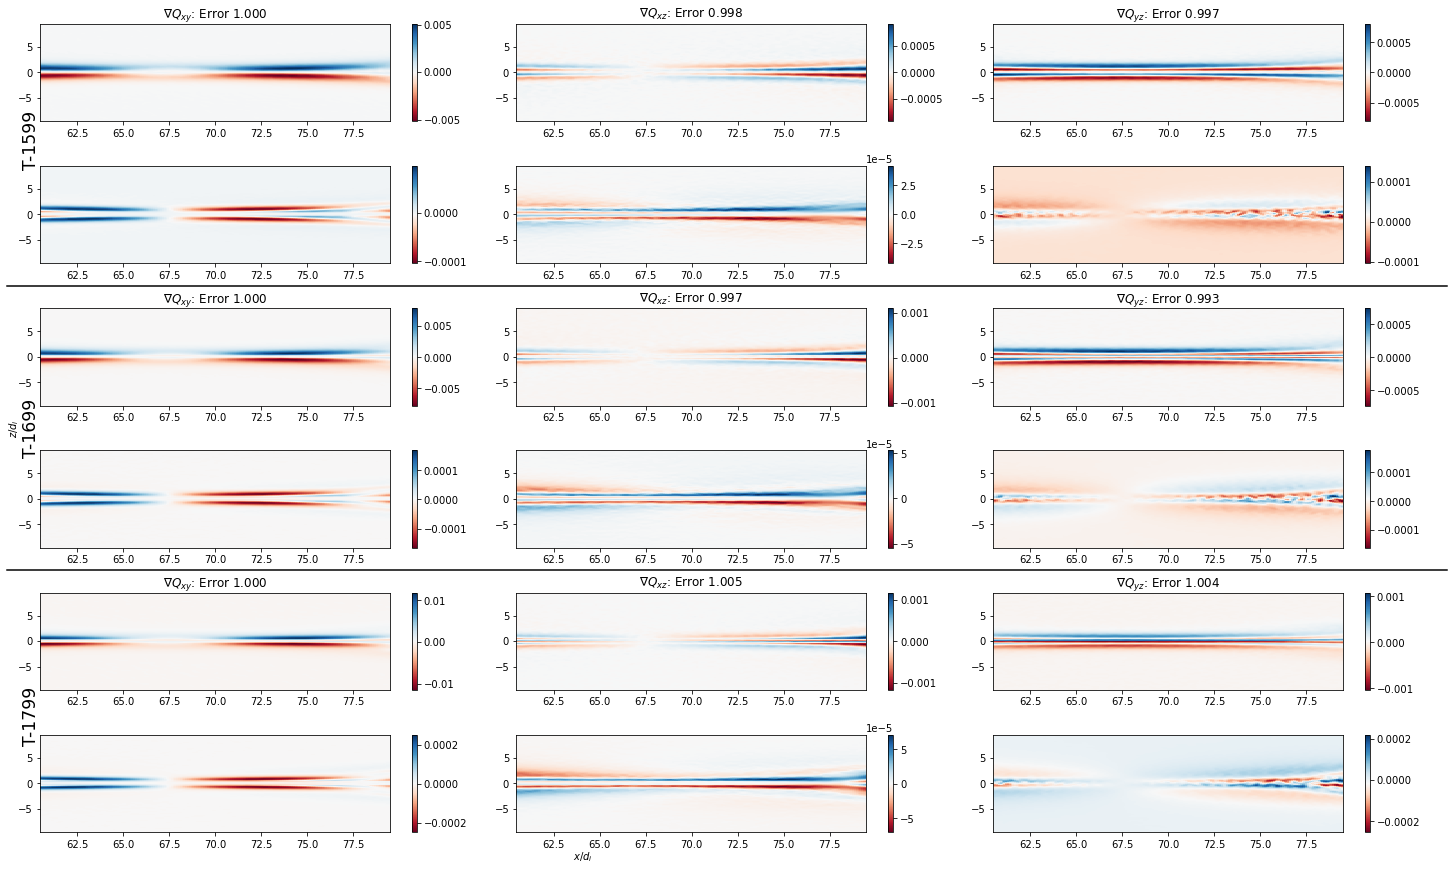

In [37]:
fig, axes = plt.subplots(6,3)

i=0

for time in times:
    rho1 = h5p.getH5Grid('rho_nc_e', time, zmin=zmin, zmax=zmax, xmin=xmin, xmax=xmax)[cutz:-cutz, :, cutx:-cutx]
    xlin = np.linspace(rho1.coords['x'].min(), rho1.coords['x'].max(), rho1.shape[2])
    zlin = np.linspace(rho1.coords['z'].min(), rho1.coords['z'].max(), rho1.shape[0])
    zshape,_, xshape = rho1.shape
    ex = load('ex_ec', time)
    ey = load('ey_ec', time)
    ez = load('ez_ec', time)
    bx = load('hx_fc', time)
    by = load('hy_fc', time)
    bz = load('hz_fc', time)
#     Ex = averaging(ec_to_nc(ex, dim='x'))[cutz:-cutz,cutx:-cutx].flatten()
#     Ey = averaging(ec_to_nc(ey, dim='y'))[cutz:-cutz,cutx:-cutx].flatten()
#     Ez = averaging(ec_to_nc(ez, dim='z'))[cutz:-cutz,cutx:-cutx].flatten()
#     Bx = averaging(fc_to_nc(bx, dim='x'))[cutz:-cutz,cutx:-cutx].flatten()
#     By = averaging(fc_to_nc(by, dim='y'))[cutz:-cutz,cutx:-cutx].flatten()
#     Bz = averaging(fc_to_nc(bz, dim='z'))[cutz:-cutz,cutx:-cutx].flatten()

#     n =  -prep('rho_nc_e', time)
#     n0 = -prep('rho_nc_e', time - tstep)
#     jx = prep('jx_nc_e', time)
#     jy = prep('jy_nc_e', time)
#     jz = prep('jz_nc_e', time)
#     jx0 = prep('jx_nc_e', time - tstep)
#     jy0 = prep('jy_nc_e', time - tstep)
#     jz0 = prep('jz_nc_e', time - tstep)
#     px1 = prep('px_nc_e', time)
#     px0 = prep('px_nc_e', time - tstep)
#     py1 = prep('py_nc_e', time)
#     py0 = prep('py_nc_e', time - tstep)
#     pz1 = prep('pz_nc_e', time)
#     pz0 = prep('pz_nc_e', time - tstep)

#     pxx1 = prep('txx_nc_e', time)
#     pxx0 = prep('txx_nc_e', time - tstep)
#     pyy1 = prep('tyy_nc_e', time)
#     pyy0 = prep('tyy_nc_e', time - tstep)
#     pzz1 = prep('tzz_nc_e', time)
#     pzz0 = prep('tzz_nc_e', time - tstep)
#     pxy1 =  prep('txy_nc_e', time)
#     pxy0 = prep('txy_nc_e', time-tstep)
#     pxz1 = prep('tzx_nc_e', time)
#     pxz0 = prep('tzx_nc_e', time - tstep)
#     pyz1 =  prep('tyz_nc_e', time)
#     pyz0 = prep('tyz_nc_e', time - tstep)

#     jx1, jy1, jz1 = jx, jy, jz
#     u1, u0 = -jx1, -jx0
#     v1, v0 = -jy1, -jy0
#     w1, w0 = -jz1, -jz0
#     r = -1
#     n1 = n

    qxxx = averaging(load('qxxx_nc_e', time))
    qxxz = averaging(load('qxxz_nc_e', time))
    d_qxxx_dx = d_dx(qxxx)
    d_qxxz_dz = d_dz(qxxz)
    div_qxx = d_qxxx_dx + d_qxxz_dz

    qyyx = averaging(load('qyyx_nc_e', time))
    qyyz = averaging(load('qyyz_nc_e', time))
    d_qyyx_dx = d_dx(qyyx)
    d_qyyz_dz = d_dz(qyyz)
    div_qyy = d_qyyx_dx + d_qyyz_dz

    qzzx = averaging(load('qzzx_nc_e', time))
    qzzz = averaging(load('qzzz_nc_e', time))
    d_qzzx_dx = d_dx(qzzx)
    d_qzzz_dz = d_dz(qzzz)
    div_qzz = d_qzzx_dx + d_qzzz_dz
    
    qxyx = averaging(load('qxxy_nc_e', time))
    qxyz = averaging(load('qxyz_nc_e', time))
    d_qxyx_dx = d_dx(qxyx)
    d_qxyz_dz = d_dz(qxyz)
    div_qxy = d_qxyx_dx + d_qxyz_dz
    
    qxzx = qxxz
    qxzz = qzzx
    d_qxzx_dx = d_dx(qxzx)
    d_qxzz_dz = d_dz(qxzz)
    div_qxz = d_qxzx_dx + d_qxzz_dz
    
    qyzx = qxyz
    qyzz = averaging(load('qzzy_nc_e', time))
    d_qyzx_dx = d_dx(qyzx)
    d_qyzz_dz = d_dz(qyzz)
    div_qyz = d_qyzx_dx + d_qyzz_dz
    
    ### Closure calculations done with the centered moment quantities, which is what c stands for

    c_prep = lambda x, t: averaging(h5p.getH5Grid(x, t, zmin=zmin, zmax=zmax, xmin=xmin, xmax=xmax).data[:,0,:])
    n_c =  -c_prep('rho_nc_e', time)
    px_c = c_prep('px_nc_e', time)
    py_c = c_prep('py_nc_e', time)
    pz_c = c_prep('pz_nc_e', time)
    pyy_c = c_prep('tyy_nc_e', time)
    pxx_c = c_prep('txx_nc_e', time)
    pxy_c =  c_prep('txy_nc_e', time)
    pxz_c = c_prep('tzx_nc_e', time)
    pzz_c = c_prep('tzz_nc_e', time)
    pyz_c =  c_prep('tyz_nc_e', time)

    qxxx_c = qxxx + 2*n_c*px_c*px_c*px_c - 3*px_c*pxx_c
    qxxz_c = qxxz + 2*n_c*px_c*px_c*pz_c - 2*px_c*pxz_c - pz_c*pxx_c

    qyyx_c = qyyx + 2*n_c*py_c*py_c*px_c - 2*py_c*pxy_c - px_c*pyy_c
    qyyz_c = qyyz + 2*n_c*py_c*py_c*pz_c - 2*py_c*pyz_c - pz_c*pyy_c

    qzzx_c = qxxz + 2*n_c*pz_c*pz_c*px_c - 2*pz_c*pxz_c - px_c*pzz_c
    qzzz_c = qzzz + 2*n_c*pz_c*pz_c*pz_c - 3*pz_c*pzz_c

    qxyx_c = qxyx + 2*n_c*px_c*py_c*px_c - 2*px_c*pxy_c - py_c*pxx_c
    qxyz_c = qxyx + 2*n_c*px_c*py_c*pz_c - px_c*pyz_c - py_c*pxz_c - pz_c*pxy_c

    qxzx_c = qxzx + 2*n_c*px_c*pz_c*px_c - 2*px_c*pxz_c - pz_c*pxx_c
    qxzz_c = qxzz + 2*n_c*px_c*pz_c*pz_c - 2*pz_c*pxz_c - px_c*pzz_c

    qyzx_c = qyzx + 2*n_c*py_c*pz_c*px_c - px_c*pyz_c - py_c*pxz_c - pz_c*pxy_c
    qyzz_c = qyzz + 2*n_c*py_c*pz_c*pz_c - 2*pz_c*pyz_c - py_c*pzz_c

    d_u_dx = d_dx(px_c)
    d_u_dz = d_dz(px_c)
    d_v_dx = d_dx(py_c)
    d_v_dz = d_dz(py_c)
    d_w_dx = d_dx(pz_c)
    d_w_dz = d_dz(pz_c)

    d_qxxx_c_dx = d_dx(qxxx_c)
    d_qxxz_c_dz = d_dz(qxxz_c)
    div_qxx_c = d_qxxx_c_dx + d_qxxz_c_dz

    d_qyyx_c_dx = d_dx(qyyx_c)
    d_qyyz_c_dz = d_dz(qyyz_c)
    div_qyy_c = d_qyyx_c_dx + d_qyyz_c_dz

    d_qzzx_c_dx = d_dx(qzzx_c)
    d_qzzz_c_dz = d_dz(qzzz_c)
    div_qzz_c = d_qzzx_c_dx + d_qzzz_c_dz

    d_qxyx_c_dx = d_dx(qxyx_c)
    d_qxyz_c_dz = d_dz(qxyz_c)
    div_qxy_c = d_qxyx_c_dx + d_qxyz_c_dz

    d_qxzx_c_dx = d_dx(qxzx_c)
    d_qxzz_c_dz = d_dz(qxzz_c)
    div_qxz_c = d_qxzx_c_dx + d_qxzz_c_dz

    d_qyzx_c_dx = d_dx(qyzx_c)
    d_qyzz_c_dz = d_dz(qyzz_c)
    div_qyz_c = d_qyzx_c_dx + d_qyzz_c_dz

    #cut flatten later so its easy to calculate deriviatives
    Pxx_c = (pxx_c - n_c*px_c*px_c) 
    Pyy_c = (pyy_c - n_c*py_c*py_c) 
    Pzz_c = (pzz_c - n_c*pz_c*pz_c)
    Pxy_c = (pxy_c - n_c*px_c*py_c)
    Pxz_c = (pxz_c - n_c*px_c*pz_c)
    Pyz_c = (pyz_c - n_c*py_c*pz_c)

    ### Derivatives of Pressure Tensor ###
    d_pxx_c_dx = d_dx(Pxx_c)
    d_pxx_c_dz = d_dz(Pxx_c)
    d_pyy_c_dx = d_dx(Pyy_c)
    d_pyy_c_dz = d_dz(Pyy_c)
    d_pzz_c_dx = d_dx(Pzz_c)
    d_pzz_c_dz = d_dz(Pzz_c)

    d_pxz_c_dx = d_dx(Pxz_c)
    d_pxz_c_dz = d_dz(Pxz_c)

    d_pxy_c_dx = d_dx(Pxy_c)
    d_pxy_c_dz = d_dz(Pxy_c)

    d_pyz_c_dx = d_dx(Pyz_c)
    d_pyz_c_dz = d_dz(Pyz_c)

    u1 = px_c[cutz:-cutz, cutx:-cutx].flatten()
    v1 = py_c[cutz:-cutz, cutx:-cutx].flatten()
    w1 = pz_c[cutz:-cutz, cutx:-cutx].flatten()

    Pxx_c = Pxx_c[cutz:-cutz, cutx:-cutx].flatten() 
    Pyy_c = Pyy_c[cutz:-cutz, cutx:-cutx].flatten() 
    Pzz_c = Pzz_c[cutz:-cutz, cutx:-cutx].flatten() 
    Pxy_c = Pxy_c[cutz:-cutz, cutx:-cutx].flatten() 
    Pxz_c = Pxz_c[cutz:-cutz, cutx:-cutx].flatten() 
    Pyz_c = Pyz_c[cutz:-cutz, cutx:-cutx].flatten() 

    jx = c_prep('jx_nc_e', time)[cutz:-cutz, cutx:-cutx].flatten()
    jy = c_prep('jy_nc_e', time)[cutz:-cutz, cutx:-cutx].flatten()
    jz = c_prep('jz_nc_e', time)[cutz:-cutz, cutx:-cutx].flatten()

    #Given Closure SE Calculation for comparison
    P_avg = 1/3*(Pxx_c + Pyy_c + Pzz_c)

    P_closure_xx = Pxx_c - P_avg
    P_closure_yy = Pyy_c - P_avg
    P_closure_zz = Pzz_c - P_avg
    P_closure_x = np.stack((P_closure_xx, Pxy_c, Pxz_c), -1)
    P_closure_y = np.stack((Pxy_c, P_closure_yy, Pyz_c), -1)
    P_closure_z = np.stack((Pxz_c, Pyz_c, P_closure_zz), -1)
    P_closure = np.stack((P_closure_x, P_closure_y, P_closure_z), -1)


    ### Divergence of Poynting Vector ###
    Ex_c = averaging(ec_to_nc(ex, dim='x'))
    Ey_c = averaging(ec_to_nc(ey, dim='y'))
    Ez_c = averaging(ec_to_nc(ez, dim='z'))
    Bx_c = averaging(fc_to_nc(bx, dim='x'))
    By_c = averaging(fc_to_nc(by, dim='y'))
    Bz_c = averaging(fc_to_nc(bz, dim='z'))

    d_ExBy_dx = d_dx(Ex_c*By_c)
    d_ExBy_dz = d_dz(Ex_c*By_c)

    d_ExBz_dx = d_dx(Ex_c*Bz_c)
    d_ExBz_dz = d_dz(Ex_c*Bz_c)

    d_EyBx_dx = d_dx(Ey_c*Bx_c)
    d_EyBx_dz = d_dz(Ey_c*Bx_c)

    d_EyBz_dx = d_dx(Ey_c*Bz_c)
    d_EyBz_dz = d_dz(Ey_c*Bz_c)

    d_EzBx_dx = d_dx(Ez_c*Bx_c)
    d_EzBx_dz = d_dz(Ez_c*Bx_c)

    d_EzBy_dx = d_dx(Ez_c*By_c)
    d_EzBy_dz = d_dz(Ez_c*By_c)

    Ex = Ex_c[cutz:-cutz, cutx:-cutx].flatten()
    Ey = Ey_c[cutz:-cutz, cutx:-cutx].flatten()
    Ez = Ez_c[cutz:-cutz, cutx:-cutx].flatten()
    
    coeffs_xy = [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.32413636, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]
#     [ 0.        ,  0.        ,  0.        , -1.73923295,  0.        ,
#          0.        , -0.52357376,  1.13006339,  0.        ,  0.        ,
#          0.        ,  0.        ,  0.        ,  0.        , -0.70221007,
#          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
#          1.81572033,  0.        ,  0.        ,  0.        ,  0.        ,
#          0.        ,  0.        ,  0.        ,  0.        ]
    coeffs_xz = [ 0.        ,  0.        ,  0.        ,  0.        ,  0.72948008,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -3.58951437,  0.        ,  0.        ]
#     [ 0.        ,  0.        ,  0.        ,  0.        , -2.13483336,
#          0.        ,  0.        ,  0.        ,  0.        ,  3.01908806,
#         -5.95302929,  0.        ,  0.        ,  0.        ,  0.        ,
#          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
#          0.        ,  1.08526766,  0.        ,  0.        ,  0.        ,
#          0.        , -1.96249366,  0.        ,  0.        ]
    coeffs_yz = [ 0.        ,  0.        ,  0.        ,  0.        ,  2.29060228,
         0.        ,  0.        ,  0.        ,  0.        , -3.62666319,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -2.57368894,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ]
#     [ 0.        ,  0.        ,  0.        ,  0.        , -0.36145099,
#          0.        ,  0.        ,  0.        ,  0.        ,  2.42031027,
#          2.73463055,  0.        ,  0.        ,  0.        ,  0.        ,
#          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
#          0.        ,  0.2081972 ,  8.40786677,  0.        ,  0.        ,
#         -3.0287443 ,  9.31069874,  0.        ,  0.        ]
    
    
    
    solution_xy = get_solution(coeffs_xy)
    solution_xz = get_solution(coeffs_xz)
    solution_yz = get_solution(coeffs_yz)

    pcm0 = axes[i, 0].pcolormesh(xlin, zlin, div_qxy_c.reshape(zshape, xshape), cmap='RdBu', rasterized=True)
    fig.colorbar(pcm0, ax=axes[i, 0])
#     solution_xy = 0.81642746*Pzz_c*d_w_dz + 0.51145711*u1*d_pxx_c_dx + 0.82323575*w1*d_pxy_c_dz + 0.7159555*u1*d_pzz_c_dx  + 0.58492921*w1*d_pzz_c_dz
    pcm1 = axes[i+1, 0].pcolormesh(xlin, zlin, solution_xy.reshape(zshape, xshape) , cmap='RdBu', rasterized=True)
    fig.colorbar(pcm1, ax=axes[i+1, 0])
    axes[i,0].set_title(rf'$\nabla Q_{{xy}}$: Error {SE(div_qxy_c, solution_xy):.3f}')
    
    
    pcm0 = axes[i, 1].pcolormesh(xlin, zlin, div_qxz_c.reshape(zshape, xshape), cmap='RdBu', rasterized=True)
    fig.colorbar(pcm0, ax=axes[i, 1])
#     solution_xz = 1.01984924*u1*d_pxz_c_dx
    pcm1 = axes[i+1, 1].pcolormesh(xlin, zlin, solution_xz.reshape(zshape, xshape) , cmap='RdBu', rasterized=True)
    fig.colorbar(pcm1, ax=axes[i+1, 1])
    axes[i,1].set_title(rf'$\nabla Q_{{xz}}$: Error {SE(div_qxz_c, solution_xz):.3f}')
    
    pcm0 = axes[i, 2].pcolormesh(xlin, zlin, div_qyz_c.reshape(zshape, xshape), cmap='RdBu', rasterized=True)
    fig.colorbar(pcm0, ax=axes[i, 2])
#     solution_yz = 1.11252224*u1*d_pyz_c_dx
    pcm1 = axes[i+1, 2].pcolormesh(xlin, zlin, solution_yz.reshape(zshape, xshape) , cmap='RdBu', rasterized=True)
    fig.colorbar(pcm1, ax=axes[i+1, 2])
    axes[i, 2].set_title(rf'$\nabla Q_{{yz}}$: Error {SE(div_qyz_c, solution_yz):.3f}')
    i += 2
    
fig.tight_layout()
## copied from https://stackoverflow.com/questions/26084231/draw-a-separator-or-lines-between-subplots/55465138#55465138
# Get the bounding boxes of the axes including text decorations
r = fig.canvas.get_renderer()
get_bbox = lambda ax: ax.get_tightbbox(r).transformed(fig.transFigure.inverted())
bboxes = np.array(list(map(get_bbox, axes.flat)), mtrans.Bbox).reshape(axes.shape)

#Get the minimum and maximum extent, get the coordinate half-way between those
ymax = np.array(list(map(lambda b: b.y1, bboxes.flat))).reshape(axes.shape).max(axis=1)
ymin = np.array(list(map(lambda b: b.y0, bboxes.flat))).reshape(axes.shape).min(axis=1)
ys = np.c_[ymax[1:], ymin[:-1]].mean(axis=1)

# Draw a horizontal lines at those coordinates
for i, y in enumerate(ys):
    if i % 2 == 0:
        continue
    line = plt.Line2D([0,1],[y,y], transform=fig.transFigure, color="black")
    fig.add_artist(line)
    
# axes[0,0].text(0.5, 1, 'xx', ha='center', fontsize='xx-large')
# axes[0,1].text(0.5, 1, 'yy', ha='center', fontsize='xx-large')
# axes[0,2].text(0.5, 1, 'zz', ha='center', fontsize='xx-large')
fig.text(0.01, 1/6, f'T-{time_labels[2]:.0f}', va='center', rotation='vertical', fontsize='xx-large')    
fig.text(0.01, 3/6, f'T-{time_labels[1]:.0f}', va='center', rotation='vertical', fontsize='xx-large') 
fig.text(0.01, 5/6, f'T-{time_labels[0]:.0f}', va='center', rotation='vertical', fontsize='xx-large')   
xlx, xly = 0.4, 0.0
zlx, zly = 0.0, 0.5
xlabel, zlabel = r'$x/d_i$', r'$z/d_i$'
fig.text(xlx, xly, xlabel, ha='center')
fig.text(zlx, zly, zlabel, va='center', rotation='vertical')

fig.savefig('closure_discovered_off_diag.pdf')

In [30]:
def get_string(coeffs):
    terms = """[k_0*vt*Pxx_c,
                        k_0*vt*Pyy_c,
                        k_0*vt*Pzz_c,
                        k_0*vt*Pxy_c,
                        k_0*vt*Pxz_c,
                        k_0*vt*Pyz_c,
                        Pxx_c*d_u_dx,
                        Pxy_c*d_u_dx,
                        Pyz_c*d_w_dz,
                        Pxz_c*d_u_dx,
                        Pxz_c*d_w_dz,
                        Pzz_c*d_w_dz,
                        d_EyBz_dx - d_EzBy_dx,
                        d_ExBy_dz - d_EyBx_dz,
                        jx*Ex, jy*Ey, jz*Ez,
                        u1*d_pxx_c_dx,
                        w1*d_pxx_c_dz,
                        u1*d_pxy_c_dx,
                        w1*d_pxy_c_dz,
                        u1*d_pxz_c_dx,
                        w1*d_pxz_c_dz,
                        u1*d_pyy_c_dx,
                        w1*d_pyy_c_dz,
                        u1*d_pyz_c_dx,
                        w1*d_pyz_c_dz,
                        u1*d_pzz_c_dx,
                        w1*d_pzz_c_dz,
                        ]"""
    names = terms.strip('[').strip(']').split(',')
    clean_names = []
    for n in names:
        if '\n' in n:
            n = n.strip('\n')
            n = n.strip()
        clean_names.append(n)
    clean_names.pop()
    string = ''
    for c, n in zip(coeffs, clean_names):
        if c != 0:
            string += f'{c:.2f}' + n + ' + '
    return string[:-2]
get_string(coeffs_xx)

'2.85k_0*vt*Pyy_c + -3.11k_0*vt*Pzz_c + 1.70Pxx_c*d_u_dx + -1.33 jy*Ey + 2.52w1*d_pxx_c_dz + 3.28u1*d_pzz_c_dx '

In [31]:
get_string(coeffs_yy)

'0.80k_0*vt*Pzz_c + 1.27Pxz_c*d_u_dx + 1.46Pxz_c*d_w_dz + -2.83w1*d_pxx_c_dz + 1.51u1*d_pzz_c_dx '

In [32]:
get_string(coeffs_zz)

'-1.09k_0*vt*Pxz_c + -2.58Pyz_c*d_w_dz + 2.84Pxz_c*d_u_dx + -1.83Pxz_c*d_w_dz + 1.17u1*d_pxz_c_dx + 4.30w1*d_pxz_c_dz + 1.89u1*d_pyz_c_dx + -1.06u1*d_pzz_c_dx + -3.94w1*d_pzz_c_dz '

In [33]:
get_string(coeffs_xy)

'1.32w1*d_pxy_c_dz '

In [34]:
get_string(coeffs_xz)

'0.73k_0*vt*Pxz_c + -3.59w1*d_pyz_c_dz '

In [35]:
get_string(coeffs_yz)

'2.29k_0*vt*Pxz_c + -3.63Pxz_c*d_u_dx + -2.57u1*d_pxz_c_dx '

$-0.361k_0v_tP_{xz} + 2.420P_{xz}\partial_xu_x + 2.735P_{xz}\partial_zu_z + 0.208u_x\partial_xP_{xz} + 8.408u_z\partial_zP_{xz} - 3.029u_x\partial_xP_{yz} + 9.311u_z\partial_zP_{yz}$